# Import, Install and Mount

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import time

from scipy import stats
from scipy.stats import randint

from imblearn.over_sampling import SMOTE
from boruta import BorutaPy

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import ElasticNet

from sklearn.naive_bayes import BernoulliNB
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import RFE
from sklearn.tree import export_graphviz
from sklearn.svm import SVC
from sklearn.svm import SVR


from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve 

%matplotlib inline

import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

import warnings
warnings.filterwarnings('ignore')

In [3]:
import os
def main():
    print("Current Working Directory " , os.getcwd())
    if os.path.exists("C:/Users/micha.DESKTOP-8HA2IGV/OneDrive/Programming/Propulsion Project/intelligencia_backup/intelligencia") :
        # Change the current working Directory    
        os.chdir("C:/Users/micha.DESKTOP-8HA2IGV/OneDrive/Programming/Propulsion Project/intelligencia_backup/intelligencia")
        print("New Working Directory " , os.getcwd())
    else:
        print("Can't change the Current Working Directory")    
        print("Current Working Directory " , os.getcwd())
if __name__ == '__main__':
    main()

Current Working Directory  C:\Users\micha.DESKTOP-8HA2IGV\OneDrive\Programming\Propulsion Project\intelligencia_backup\intelligencia
New Working Directory  C:\Users\micha.DESKTOP-8HA2IGV\OneDrive\Programming\Propulsion Project\intelligencia_backup\intelligencia


In [4]:
#from google.colab import drive
#drive.mount('/content/drive')

# Data Preparation Class
- Read Data
- Standard Deviation Filter
- Split Function
- Smote Upsampling


In [5]:
class DataPrep:
    def __init__(self, seed):
        self.seed = seed
    
  # Read Data
    def read_data(self, path, nrows, usecols):
        data = pd.read_csv(path, nrows=nrows, usecols=usecols)
        data.index = data.iloc[:,0]
        data.drop(columns = "Unnamed: 0", inplace = True)
        data.columns = [(re.sub('\.\d+', '', gene)) for gene in data.columns]
        return data
  
  # Filter with Standard Deviation Threshold
    def X_and_y(self, data, threshold):
        #data.describe()
        X = data.drop(columns = 'label')
        X_sd = X.loc[:, X.std() > threshold]
        y = data[["label"]]
        return X_sd, y
  
  # Train Test Split data
    def split(self, X, y, test_size):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=self.seed)
        return X_train, X_test, y_train, y_test
  
  # Upsample unbalanced data
    def smote_up(self, X_train, y_train):
        #print("Before OverSampling, counts of label '1': {}".format(sum(y_train['label']==1)))
        #print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train['label']==0)))

        sm = SMOTE(random_state=self.seed)
        X_train_smote, y_train_smote = sm.fit_sample(X_train, y_train)

        #print('After OverSampling, the shape of train_X: {}'.format(X_train_smote.shape))
        #print('After OverSampling, the shape of train_y: {} \n'.format(y_train_smote.shape))

        #print("After OverSampling, counts of label '1': {}".format(sum(y_train_smote==1)))
        #print("After OverSampling, counts of label '0': {}".format(sum(y_train_smote==0)))
        column_names = X_train.columns

        # Make dataframe again
        X_train_smote = pd.DataFrame(X_train_smote, columns=column_names)
        y_train_smote = pd.DataFrame(y_train_smote, columns=['label'])

        return X_train_smote, y_train_smote
    
    def bulbasaur(self, path, threshold = 2, nrows = None, usecols = None):
        data = self.read_data(path, nrows, usecols)
        X, y = self.X_and_y(data, threshold)
        X_train, X_test, y_train, y_test = self.split(X, y, 0.3)
        X_train_smote, y_train_smote = self.smote_up(X_train, y_train)
        return X_train_smote, y_train_smote, X_test, y_test
    
dataprep = DataPrep(1888)

In [ ]:
path = "Output/Chunk_Thyroid_ThyroidGland.csv"
X_train, y_train, X_test, y_test = dataprep.bulbasaur(path, threshold = 0)

# Feature Selection Class
- Boruta
- RFE
- Gradient Boost Classifier
- Elastic Net
- Visualisation 
- Call Methods

In [1]:
class FeatureSelection:
    def __init__(self, seed):
        self.seed = seed
    
    def rfe(self, X_train, y_train, X_test, y_test, n_features = 300, step = 0.2, kernel = "linear"):
        """
        Recursive Feature Elimination - step < 1 is a percentage. Returns selected features.
        """
        # Create RFE
        estimator = SVR(kernel=kernel)
        selector = RFE(estimator, n_features_to_select = n_features, step=step)
        selector = selector.fit(X_train.to_numpy(), y_train.to_numpy())
        
        # Print Accuracy
        print('Accuracy of RFE: {:.3f}'.format(selector.score(X_test, y_test)))
        
        # Add features and feature importance to dictionary
        selected_features = X_train.columns[selector.support_].tolist()
        
        feature_importances = [1 for x in range(len(selected_features))]
    
        dictionary = {"Recursive Feature Elimination":[selected_features, feature_importances]}
        return dictionary
  
  
    def gradient_boost_classifier(self, X_train, y_train, X_test, y_test, n_features = 300):
        """
        Gradient Boost Classifier with feature importance selection.
        """
        # Create Gradient Boost Classifier 
        new = GradientBoostingClassifier(learning_rate=0.1, n_estimators=250, max_depth=4, \
                                         min_samples_split=8, min_samples_leaf=1,\
                                         subsample=0.75, random_state=self.seed)
        new.fit(X_train,y_train)
        predictors = list(X_train)
        feat_imp = pd.Series(new.feature_importances_, predictors).sort_values(ascending=False)[:n_features]
        
        pred = new.predict(X_test)
        
        # Print accuracy
        print('Accuracy of GBM: {:.3f}'.format(new.score(X_test, y_test)))
    
        # Add features and feature importance to dictionary
        importances = new.feature_importances_
        genes = X_test.columns
        
        selected_features_df = pd.DataFrame(importances, index = genes).sort_values(0, ascending = False).head(n_features)
        selected_features = selected_features_df.index.tolist()
        feature_importances = selected_features_df.iloc[:,0].tolist()
        
        dictionary = {"Gradient Boost Classifier":[selected_features, feature_importances]}
        return dictionary
    
    def elastic_net(self, X_train_smote, y_train_res, X_test, y_test, alpha=0.01, l1_ratio=0.5, n_features=300):
        clf = ElasticNet(random_state=self.seed, alpha=alpha, l1_ratio=l1_ratio)
        clf.fit(X_train_smote, y_train_res)

        clf.pred = clf.predict(X_test)

        print("Accuracy of Elastic Net: {:.3f}".format(clf.score(X_test, y_test)))
        #print("Elastic net mean squared error: {:.3f}".format(mean_squared_error(y_test, clf.pred)))

        ft_imp = pd.DataFrame(clf.coef_, index=X_train_smote.columns)
        ft_sort = ft_imp.sort_values(0, ascending=False)
        imp_coef = pd.concat([ft_sort.head(int(n_features/2)), ft_sort.tail(int(n_features/2))])

        selected_features = imp_coef.index.tolist()
        feature_importances = imp_coef.iloc[:,0].tolist()

        dictionary = {"Elastic Net": [selected_features, feature_importances]}

        return dictionary 
  
    def boruta_tree(self, X_train_smote, y_train_res, X_test, y_test):

        for _ in range(1):

            from sklearn.metrics import f1_score # import again because it works like that :)

            # Random Forests for Boruta
            rf_boruta = RandomForestClassifier(n_jobs=-1, random_state=self.seed)

            # Perform Boruta
            boruta = BorutaPy(rf_boruta, n_estimators='auto', verbose=0,
                          alpha=0.005, max_iter=30, perc=100, random_state=self.seed)
            boruta.fit(X_train_smote.values, y_train_res)

            # Select features and fit Logistic Regression

            cols = X_train_smote.columns[boruta.support_]
            X_train_smote = X_train_smote[cols]
            est_boruta = LogisticRegression(random_state=self.seed)
            est_boruta.fit(X_train_smote, y_train_res)

            scores = cross_val_score(est_boruta, X_train_smote, y_train_res, cv=5)

            print("Accuracy of Boruta: %0.3f (+/- %0.3f)" % (scores.mean(), scores.std() * 2))

        # Random Forest for extracting features

        X_filtered = X_train_smote[cols]

        rf = RandomForestClassifier(n_estimators = 10, criterion = 'gini', random_state = self.seed)
        rf.fit(X_filtered, y_train_res)
        rf_pred = rf.predict(X_test[cols])
        print("Accuracy of Boruta Tree: {:.3f}".format(accuracy_score(y_test, rf_pred)))

        feature_names = X_filtered.columns
        rf_coeff = pd.DataFrame({"feature": feature_names,"coefficient": rf.feature_importances_})
        rf_coeff_top = rf_coeff.sort_values(by="coefficient",ascending=False).head(300).set_index("feature")

        selected_features = rf_coeff_top.index.tolist()
        feature_importances = rf_coeff_top.coefficient.tolist()

        dictionary = {"Boruta Tree": [selected_features, feature_importances]}

        return dictionary
  
    def visualize_selected_features(self, X, y, selected_features):
        """
        Visualize features
        """
        X_selected = X[selected_features]

        import seaborn as sns
        fig = plt.figure(figsize = (20, 25))
        j = 0
        for i in X_selected.columns:
            plt.subplot(14, 10, j+1)
            j += 1
            sns.distplot(X_selected[i][y["label"]==0], color='g', label = '0')
            sns.distplot(X_selected[i][y["label"]==1], color='r', label = '1')
            plt.legend(loc='best')
        fig.suptitle('Target Data Analysis')
        fig.tight_layout()
        fig.subplots_adjust(top=0.95)
        plt.show() 
        
        
    def call_methods(self, X_train, y_train, X_test, y_test):
        method1 = self.gradient_boost_classifier(X_train, y_train, X_test, y_test, n_features = 300)
        method2 = self.rfe(X_train, y_train, X_test, y_test, kernel = "linear")
        method3 = self.elastic_net(X_train, y_train, X_test, y_test, alpha=0.01, l1_ratio=0.5, n_features = 300)
        method4 = self.boruta_tree(X_train, y_train, X_test, y_test)

        return { **method1, **method2, **method3, **method4 }
        
# Instantiate Class Object
FS = FeatureSelection(1888)

In [24]:
X_train.head().sample(100, axis = 1, random_state = FS.seed)

,ENSG00000133250,ENSG00000070366,ENSG00000111670,ENSG00000182185,ENSG00000213799,ENSG00000065923,ENSG00000185158,ENSG00000105393,ENSG00000269476,ENSG00000079337,...,ENSG00000095596,ENSG00000102804,ENSG00000130876,ENSG00000137074,ENSG00000169900,ENSG00000103187,ENSG00000132613,ENSG00000129194,ENSG00000198271,ENSG00000173077
0,4.5808,4.5098,3.5274,1.6875,0.1648,2.3251,2.4035,5.3586,-1.5951,6.4609,...,-9.9658,6.9516,0.6145,3.7804,-2.8262,5.8468,2.6693,0.2400,-9.9658,-9.9658
1,3.9737,4.8228,4.2312,1.6420,-0.6873,1.9340,3.1079,5.3498,-9.9658,7.0128,...,-3.4580,7.7783,-2.8262,3.5399,-9.9658,4.7991,3.2617,-0.0877,-9.9658,-6.5064
2,4.7318,4.9093,4.5766,2.3308,1.2815,2.3019,2.8877,5.8795,-1.7809,6.8329,...,-3.0469,7.4543,-2.3884,4.2373,-1.6850,5.2619,3.3192,-1.1488,-9.9658,-5.5735
3,4.9137,5.3162,4.1458,1.8484,-0.5973,1.7954,3.8491,5.3064,-1.9379,6.9268,...,-0.3752,8.9822,-1.6850,3.7720,-9.9658,5.0050,3.0481,1.2636,-9.9658,-9.9658
4,4.0109,4.0109,4.3499,2.3926,0.5271,2.3164,2.3251,5.2495,-2.7274,6.0873,...,0.5370,6.7922,-9.9658,3.4778,-2.8262,5.6854,3.7389,-1.1172,-9.9658,-6.5064


In [28]:
y_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 698 entries, 0 to 697
Data columns (total 1 columns):
label    698 non-null int64
dtypes: int64(1)
memory usage: 5.5 KB


In [34]:
sel_feat = ['ENSG00000132693',
 'ENSG00000070193',
 'ENSG00000039537',
 'ENSG00000149451',
 'ENSG00000157150',
 'ENSG00000262180',
 'ENSG00000104879',
 'ENSG00000189058',
 'ENSG00000111245',
 'ENSG00000197561',
 'ENSG00000185513',
 'ENSG00000179532',
 'ENSG00000129467',
 'ENSG00000108963',
 'ENSG00000155511',
 'ENSG00000124440',
 'ENSG00000184058',
 'ENSG00000124208',
 'ENSG00000159455',
 'ENSG00000105605',
 'ENSG00000137392',
 'ENSG00000250067',
 'ENSG00000173432',
 'ENSG00000239839',
 'ENSG00000163516',
 'ENSG00000162490',
 'ENSG00000204149',
 'ENSG00000144785',
 'ENSG00000267022',
 'ENSG00000021461',
 'ENSG00000160882',
 'ENSG00000267059',
 'ENSG00000122136',
 'ENSG00000100433',
 'ENSG00000275714',
 'ENSG00000172346',
 'ENSG00000197893',
 'ENSG00000170367',
 'ENSG00000281028',
 'ENSG00000110484',
 'ENSG00000162897',
 'ENSG00000022556',
 'ENSG00000163737',
 'ENSG00000137869',
 'ENSG00000154263',
 'ENSG00000170373',
 'ENSG00000147588',
 'ENSG00000141371',
 'ENSG00000275410',
 'ENSG00000240247',
 'ENSG00000165837',
 'ENSG00000140465',
 'ENSG00000130720',
 'ENSG00000254995',
 'ENSG00000268173',
 'ENSG00000235268',
 'ENSG00000186471',
 'ENSG00000231924',
 'ENSG00000269028',
 'ENSG00000206013',
 'ENSG00000184258',
 'ENSG00000154478',
 'ENSG00000099949',
 'ENSG00000096088',
 'ENSG00000104760',
 'ENSG00000184937',
 'ENSG00000139574',
 'ENSG00000171195',
 'ENSG00000012817',
 'ENSG00000034971',
 'ENSG00000270617',
 'ENSG00000204866',
 'ENSG00000182545',
 'ENSG00000198099',
 'ENSG00000145864',
 'ENSG00000270136',
 'ENSG00000185988',
 'ENSG00000112077',
 'ENSG00000271321',
 'ENSG00000248329',
 'ENSG00000170558',
 'ENSG00000182256',
 'ENSG00000164970',
 'ENSG00000206047',
 'ENSG00000268083',
 'ENSG00000243716',
 'ENSG00000149021',
 'ENSG00000171557',
 'ENSG00000244355',
 'ENSG00000154258',
 'ENSG00000171560',
 'ENSG00000167768',
 'ENSG00000175535',
 'ENSG00000223501',
 'ENSG00000197353',
 'ENSG00000198211',
 'ENSG00000186732',
 'ENSG00000145920',
 'ENSG00000221978',
 'ENSG00000152977']

In [37]:
sel_feat[0]

'ENSG00000132693'

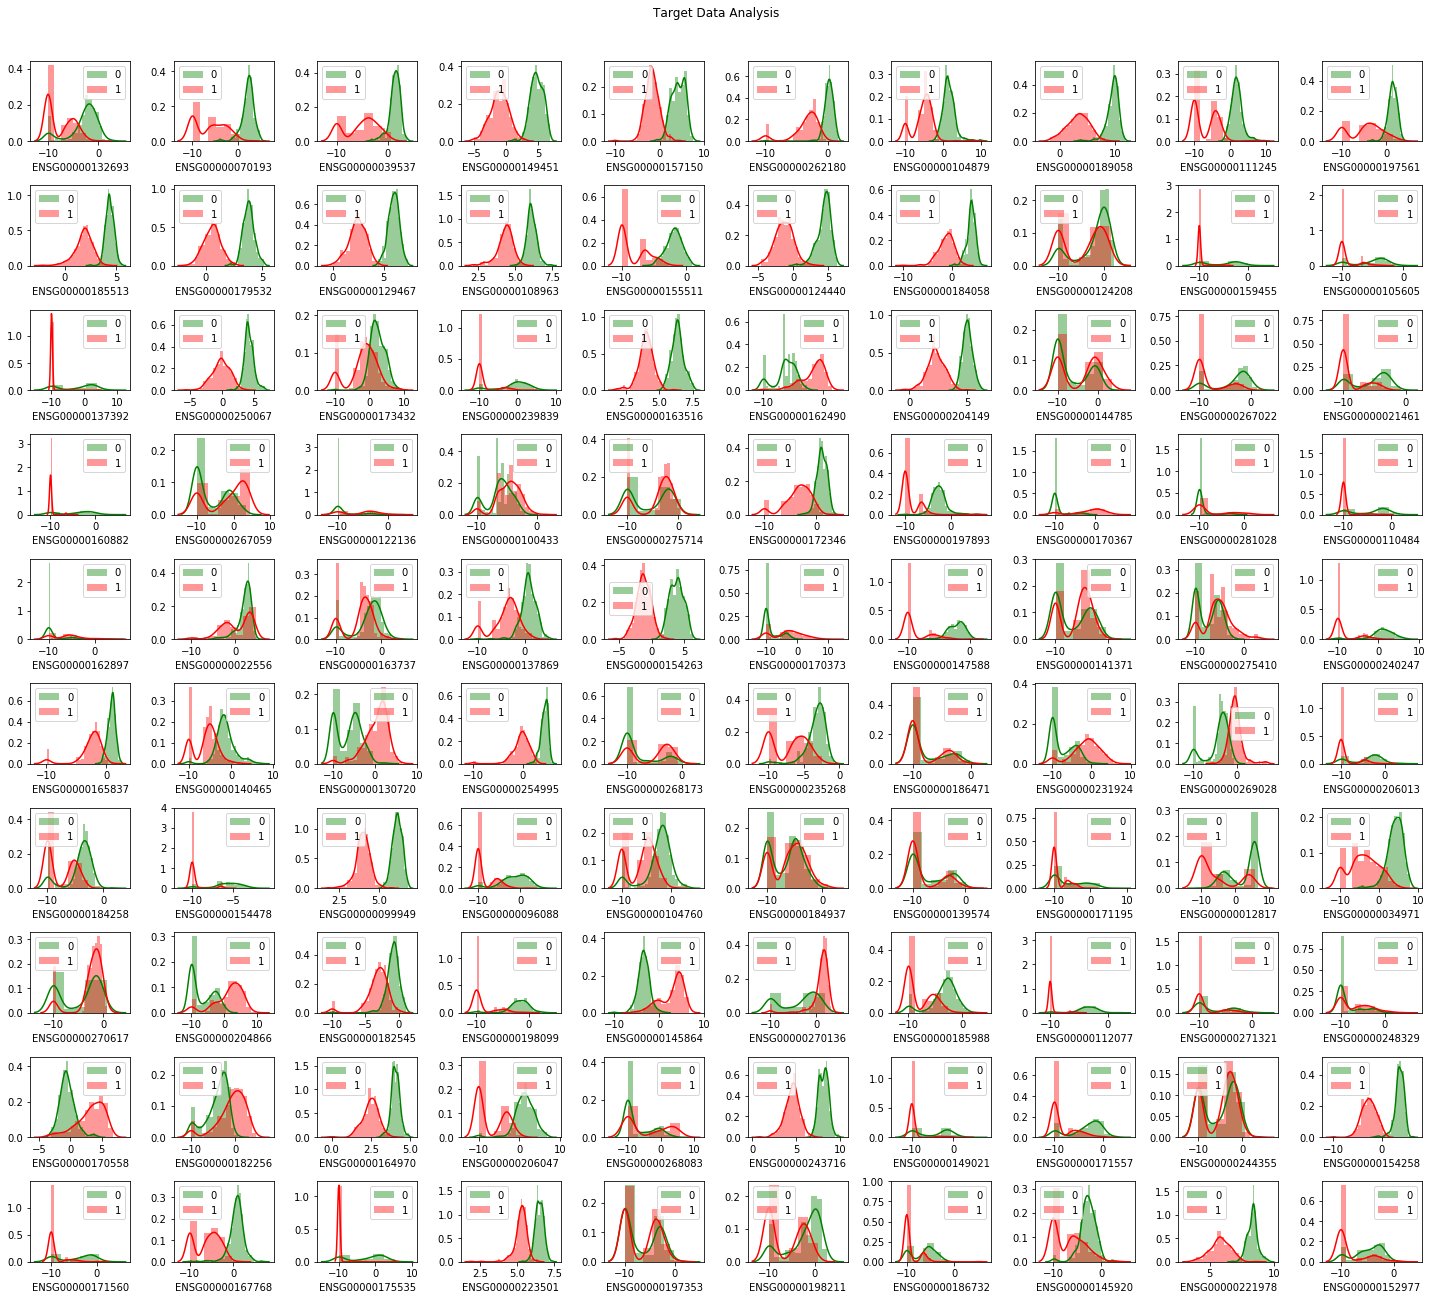

In [35]:
FS.visualize_selected_features(X_train, y_train, sel_feat)

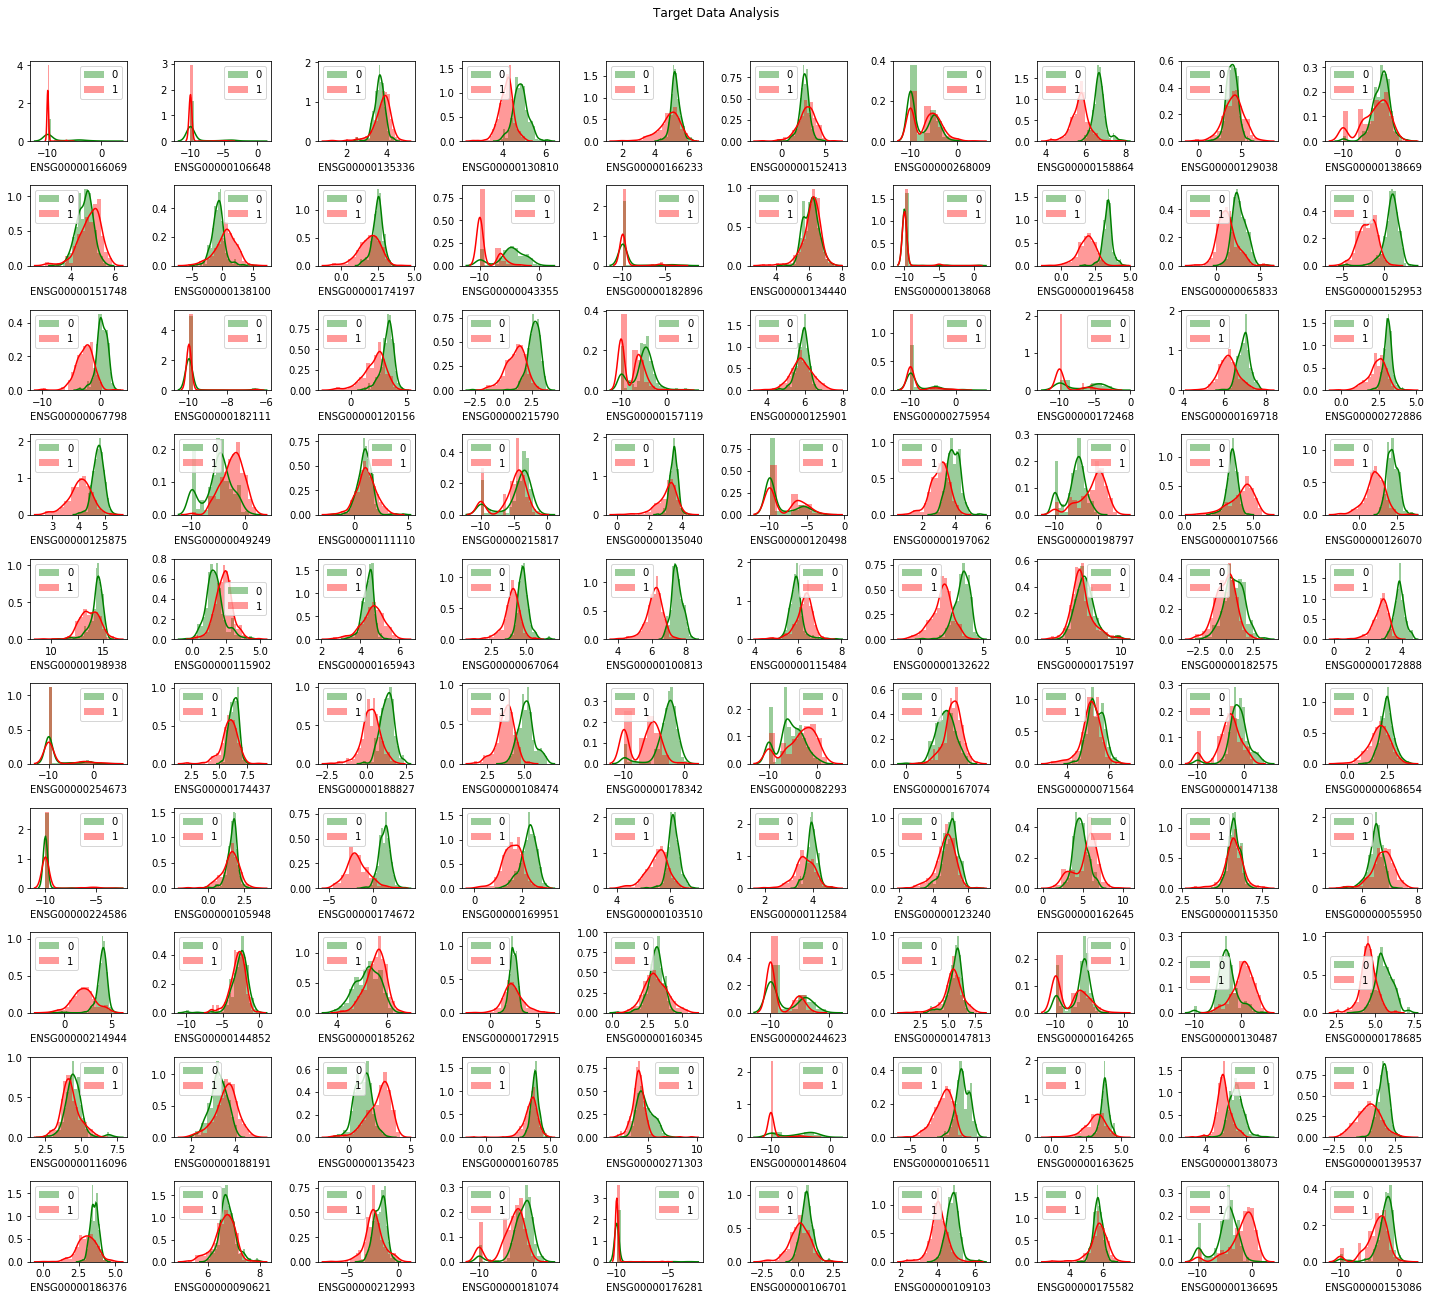

In [33]:
FS.visualize_selected_features(X_train, y_train, X_train.sample(100, axis = 1, random_state = 987654321).columns)

# Results

- Combine Intogen Genes with TCGA
- Compare Models

In [7]:
class Evaluation:
    
    def add_intogen_to_dict(self, path, dict_list):
        """
        Add a dictionary with Intogen genes and corresponding Mutation Count
        """
        #path = "Data/Intogen_Data/Lung_Adenocarcinoma_LUAD_TCGA.tsv"
        intogen_df = pd.read_csv(path, delimiter = "\t")
        importances = intogen_df["MUTS_PAM_SAMPLES"].to_list()
        intogen_genes = {"Intogen":[intogen_df["GENE"].to_list(), importances]}
        dict_list = {**dict_list, **intogen_genes}
        
        return dict_list
    
    def results(self, dict_list):
        """
        Store results in a csv
        Includes: Count for each method, feature importance, intogen counts
        """
        row_names = []
        column_names = []

        # Create dataframe with all viable genes from all method results
        for method, selected_features in dict_list.items():
            
            for feature in selected_features[0]:
                row_names.append(feature)

            row_names = list(set(row_names))
            column_names.append(method)

        results = pd.DataFrame(columns = column_names, index = row_names)
        results.fillna(0, inplace = True)

        # Add a one where the method selected the corresponding feature
        for method, selected_features in dict_list.items():
            for feature in selected_features[0]:
                results.at[feature, method] = 1


        # Create Column with total count
        results['Total Count'] = results[list(results.columns)].sum(axis=1)
        results.sort_values(by = "Total Count", ascending = False, inplace = True)
        
        # Add Importance Columns
        for method, selected_features in dict_list.items():
            additional = pd.DataFrame({"Importances: " + method:selected_features[1]}, index = selected_features[0])
            results = results.join(additional, on=results.index, how='left')
        
        # Clean dataframe
        results.fillna(0, inplace = True)
        
        ordered_columns = ['Total Count', 'Intogen', 'Gradient Boost Classifier', 'Recursive Feature Elimination', 'Elastic Net', 'Boruta Tree',  'Importances: Gradient Boost Classifier','Importances: Recursive Feature Elimination','Importances: Elastic Net', 'Importances: Boruta Tree','Importances: Intogen']
        results = results[ordered_columns]
        return results
    
    def final_results(self, path, path_intogen, nrows = 200, usecols = [x for x in range(100)], threshold = 3):
        """
        Puts everything together
        """
        X_train, y_train, X_test, y_test = dataprep.bulbasaur(path, threshold, nrows = nrows, usecols = usecols)
        dict_list = FS.call_methods(X_train, y_train, X_test, y_test)
        dict_list = evaluation.add_intogen_to_dict(path_intogen, dict_list)
        df = evaluation.results(dict_list)
        #df.to_csv("Breast_results.csv")
        return df

    def iterate_trough_cancers(self, path_list, path_intogen_list, nrows, usecols, threshold = 2.5):
        """
        Iterate through all cancer data
        """
        for path, path_intogen in zip(path_list, path_intogen_list):
            start = time.time()
            name = re.sub("^.+\/Chunk_", "", path)
            filepath = 'Output/Result_{}'.format(name)

            print('Evaluating {}'.format(path))      

            results = evaluation.final_results(path, path_intogen, nrows = nrows, usecols = usecols, threshold = threshold)            
            results.to_csv(filepath)

            print('Finished in {:.1f} min\n'.format((time.time() - start) / 60))

evaluation = Evaluation()

# Apply

In [15]:
path_intogen_list = [#"Data/Intogen/Breast_Invasive_BRCA_TCGA.tsv", 
                    #"Data/Intogen/Lung_Adenocarcinoma_LUAD_TCGA.tsv", 
                    #"Data/Intogen/Lung_Squamous_Cell_LUSC_TCGA.tsv", 
                    #"Data/Intogen/Skin_Cutaneous_Melanoma_CM_TCGA.tsv", 
                    #"Data/Intogen/Thyroid_Carcinoma_THCA_TCGA.tsv",
                    "Data/Intogen/AllCancers.tsv",
                    "Data/Intogen/AllCancers.tsv"]
path_list = [#"Output/Chunk_Breast.csv",
            #"Output/Chunk_LungAdenocarcinoma_Lung.csv",
            #"Output/Chunk_LungSquamousCellCarcinoma_Lung.csv",
            #"Output/Chunk_Skin.csv",
            #"Output/Chunk_Thyroid_ThyroidGland.csv",
            "Output/Chunk_LungA1_vs_LungS1.csv",
            "Output/Chunk_AllCancers_0vs1.csv"]

In [18]:
evaluation.iterate_trough_cancers(
    path_list,
    path_intogen_list, nrows = None, usecols = None, threshold = 0)

Evaluating Output/Chunk_LungA1_vs_LungS1.csv
Accuracy of GBM: 0.947
Accuracy of RFE: 0.797
Accuracy of Elastic Net: 0.817
Accuracy of Boruta: 0.965 (+/- 0.023)
Accuracy of Boruta Tree: 0.951
Finished in 28.0 min

Evaluating Output/Chunk_AllCancers_0vs1.csv
Accuracy of GBM: 1.000
Accuracy of RFE: 0.975
Accuracy of Elastic Net: 0.983
Accuracy of Boruta: 1.000 (+/- 0.000)
Accuracy of Boruta Tree: 0.999
Finished in 126.8 min



In [ ]:
# Model Accuracies
"""
Evaluating Output/Chunk_Breast.csv
Accuracy of GBM: 0.994
Accuracy of RFE: 0.928
Accuracy of Elastic Net: 0.950
Accuracy of Boruta: 1.000 (+/- 0.000)
Accuracy of Boruta Tree: 1.000
Finished in 14.3 min

Evaluating Output/Chunk_LungAdenocarcinoma_Lung.csv
Accuracy of GBM: 1.000
Accuracy of RFE: 0.972
Accuracy of Elastic Net: 0.969
Accuracy of Boruta: 0.999 (+/- 0.006)
Accuracy of Boruta Tree: 1.000
Finished in 8.3 min

Evaluating Output/Chunk_LungSquamousCellCarcinoma_Lung.csv
Accuracy of GBM: 0.992
Accuracy of RFE: 0.972
Accuracy of Elastic Net: 0.976
Accuracy of Boruta: 1.000 (+/- 0.000)
Accuracy of Boruta Tree: 0.996
Finished in 7.4 min

Evaluating Output/Chunk_Skin.csv
Accuracy of GBM: 1.000
Accuracy of RFE: 0.979
Accuracy of Elastic Net: 0.981
Accuracy of Boruta: 1.000 (+/- 0.000)
Accuracy of Boruta Tree: 1.000
Finished in 6.6 min

Evaluating Output/Chunk_Thyroid_ThyroidGland.csv
Accuracy of GBM: 0.996
Accuracy of RFE: 0.960
Accuracy of Elastic Net: 0.964
Accuracy of Boruta: 1.000 (+/- 0.000)
Accuracy of Boruta Tree: 0.996
Finished in 5.7 min

Evaluating Output/Chunk_LungA1_vs_LungS1.csv
Accuracy of GBM: 0.947
Accuracy of RFE: 0.797
Accuracy of Elastic Net: 0.817
Accuracy of Boruta: 0.965 (+/- 0.023)
Accuracy of Boruta Tree: 0.951
Finished in 28.0 min

Evaluating Output/Chunk_AllCancers_0vs1.csv
Accuracy of GBM: 1.000
Accuracy of RFE: 0.975
Accuracy of Elastic Net: 0.983
Accuracy of Boruta: 1.000 (+/- 0.000)
Accuracy of Boruta Tree: 0.999
Finished in 126.8 min
""";

In [ ]:
def iterate_trough_cancers(self, path_list, path_intogen_list, nrows, usecols, threshold = 2.5):
        """
        Iterate through all cancer data
        """
        for path, path_intogen in zip(path_list, path_intogen_list):
            start = time.time()
            name = re.sub("^.+\/Chunk_", "", path)
            filepath = 'Output/Result_{}'.format(name)

            print('Evaluating {}'.format(path))      

            results = evaluation.final_results(path, path_intogen, nrows = nrows, usecols = usecols, threshold = threshold)            
            results.to_csv(filepath)

            print('Finished in {:.1f} min\n'.format((time.time() - start) / 60))


In [109]:

census

,Gene Symbol,Name,Entrez GeneId,Genome Location,Tier,Hallmark,Chr Band,Somatic,Germline,Tumour Types(Somatic),...,Cancer Syndrome,Tissue Type,Molecular Genetics,Role in Cancer,Mutation Types,Translocation Partner,Other Germline Mut,Other Syndrome,Synonyms,GENE
0,A1CF,APOBEC1 complementation factor,29974,10:50806729-50859940,2,NaN,10q11.23,yes,NaN,melanoma,...,NaN,E,NaN,oncogene,Mis,NaN,NaN,NaN,"29974,A1CF,ENSG00000148584,Q9NQ94",ENSG00000148584
1,ABI1,abl-interactor 1,10006,10:26748570-26860863,1,Yes,10p11.2,yes,NaN,AML,...,NaN,L,Dom,"TSG, fusion",T,KMT2A,NaN,NaN,"10006,ABI1,ENSG00000136754,Q8IZP0,SSH3BP1",ENSG00000136754
2,ABL1,v-abl Abelson murine leukemia viral oncogene h...,25,9:130835447-130885683,1,Yes,9q34.1,yes,NaN,"CML, ALL, T-ALL",...,NaN,L,Dom,"oncogene, fusion","T, Mis","BCR, ETV6, NUP214",NaN,NaN,"25,ABL,ABL1,ENSG00000097007,P00519",ENSG00000097007
3,ABL2,"c-abl oncogene 2, non-receptor tyrosine kinase",27,1:179107718-179143044,1,NaN,1q24-q25,yes,NaN,AML,...,NaN,L,Dom,"oncogene, fusion",T,ETV6,NaN,NaN,"27,ABL2,ABLL,ENSG00000143322,P42684",ENSG00000143322
4,ACKR3,atypical chemokine receptor 3,57007,2:236580466-236581554,1,Yes,2q37.3,yes,NaN,lipoma,...,NaN,M,Dom,"oncogene, fusion",T,HMGA2,NaN,NaN,"A8K6J4,ACKR3,CMKOR1,CXCR7,ENSG00000144476,P251...",ENSG00000144476
5,ACSL3,acyl-CoA synthetase long-chain family member 3,2181,2:222908773-222941654,1,Yes,2q36,yes,NaN,prostate,...,NaN,E,Dom,fusion,T,ETV1,NaN,NaN,"2181,ACSL3,ENSG00000123983,FACL3,O95573",ENSG00000123983
6,ACSL6,acyl-CoA synthetase long-chain family member 6,23305,5:131954234-132011553,2,NaN,5q31.1,yes,NaN,"AML, AEL",...,NaN,L,Dom,fusion,T,ETV6,NaN,NaN,"23305,ACSL6,ENSG00000164398,FACL6,Q9UKU0",ENSG00000164398
7,ACVR1,"activin A receptor, type I",90,2:157737531-157799493,1,Yes,2q23-q24,yes,NaN,DIPG,...,NaN,O,Dom,oncogene,Mis,NaN,yes,Fibrodysplasia ossificans progressiva,"90,ACVR1,ACVRLK2,ENSG00000115170,Q04771",ENSG00000115170
8,ACVR2A,activin A receptor type 2A,92,2:147845153-147927274,1,NaN,2q22.3-q23.1,yes,NaN,"large intestine carcinoma, stomach carcinoma, ...",...,NaN,E,Rec,TSG,"Mis, N, F",NaN,NaN,NaN,"92,ACVR2,ACVR2A,ENSG00000121989,P27037",ENSG00000121989
9,AFF1,"AF4/FMR2 family, member 1",4299,4:87007409-87135702,1,Yes,4q21,yes,NaN,AL,...,NaN,L,Dom,fusion,T,KMT2A,NaN,NaN,"4299,AFF1,ENSG00000172493,MLLT2,P51825,PBM1",ENSG00000172493


In [62]:
census['ensembl'] = census['Synonyms'].apply(lambda value: re.search('(ENSG\d+)', value[0]))


TypeError: 'int' object is not subscriptable

In [60]:
census["GENE"] = census["Synonyms"].str.extract(pat = '(ENSG...........)')

In [85]:
census.columns

Index(['Gene Symbol', 'Name', 'Entrez GeneId', 'Genome Location', 'Tier',
       'Hallmark', 'Chr Band', 'Somatic', 'Germline', 'Tumour Types(Somatic)',
       'Tumour Types(Germline)', 'Cancer Syndrome', 'Tissue Type',
       'Molecular Genetics', 'Role in Cancer', 'Mutation Types',
       'Translocation Partner', 'Other Germline Mut', 'Other Syndrome',
       'Synonyms', 'ENSG', 'GENE'],
      dtype='object')

In [94]:
for gene in census["Gene Symbol"].tolist():
    print(gene)

A1CF
ABI1
ABL1
ABL2
ACKR3
ACSL3
ACSL6
ACVR1
ACVR2A
AFF1
AFF3
AFF4
AKAP9
AKT1
AKT2
AKT3
ALDH2
ALK
AMER1
ANK1
APC
APOBEC3B
AR
ARAF
ARHGAP26
ARHGAP5
ARHGEF10
ARHGEF10L
ARHGEF12
ARID1A
ARID1B
ARID2
ARNT
ASPSCR1
ASXL1
ASXL2
ATF1
ATIC
ATM
ATP1A1
ATP2B3
ATR
ATRX
AXIN1
AXIN2
B2M
BAP1
BARD1
BAX
BAZ1A
BCL10
BCL11A
BCL11B
BCL2
BCL2L12
BCL3
BCL6
BCL7A
BCL9
BCL9L
BCLAF1
BCOR
BCORL1
BCR
BIRC3
BIRC6
BLM
BMP5
BMPR1A
BRAF
BRCA1
BRCA2
BRD3
BRD4
BRIP1
BTG1
BTK
BUB1B
C15orf65
C2orf44
CACNA1D
CALR
CAMTA1
CANT1
CARD11
CARS
CASC5
CASP3
CASP8
CASP9
CBFA2T3
CBFB
CBL
CBLB
CBLC
CCDC6
CCNB1IP1
CCNC
CCND1
CCND2
CCND3
CCNE1
CCR4
CCR7
CD209
CD274
CD28
CD74
CD79A
CD79B
CDC73
CDH1
CDH10
CDH11
CDH17
CDK12
CDK4
CDK6
CDKN1A
CDKN1B
CDKN2A
CDKN2C
CDX2
CEBPA
CEP89
CHCHD7
CHD2
CHD4
CHEK2
CHIC2
CHST11
CIC
CIITA
CLIP1
CLP1
CLTC
CLTCL1
CNBD1
CNBP
CNOT3
CNTNAP2
CNTRL
COL1A1
COL2A1
COL3A1
COX6C
CPEB3
CREB1
CREB3L1
CREB3L2
CREBBP
CRLF2
CRNKL1
CRTC1
CRTC3
CSF1R
CSF3R
CSMD3
CTCF
CTNNA2
CTNNB1
CTNND1
CTNND2
CUL3
CUX1
CXCR4
CYLD
CYP2C

In [100]:
#census.fillna(0, inplace= True)
census_breast = census[census["Tumour Types(Somatic)"].str.contains("breast").fillna(False)]

In [107]:
lst_breast = ['ENSG00000149451',
 'ENSG00000092054',
 'ENSG00000175832',
 'ENSG00000269028',
 'ENSG00000123500',
 'ENSG00000125740',
 'ENSG00000069011',
 'ENSG00000100985',
 'ENSG00000256500',
 'ENSG00000115507',
 'ENSG00000154997',
 'ENSG00000170373',
 'ENSG00000171864',
 'ENSG00000273047',
 'ENSG00000137745',
 'ENSG00000188133',
 'ENSG00000198842',
 'ENSG00000164283',
 'ENSG00000120875',
 'ENSG00000169627',
 'ENSG00000278677',
 'ENSG00000142700',
 'ENSG00000244694',
 'ENSG00000173535',
 'ENSG00000270136',
 'ENSG00000147889',
 'ENSG00000009709',
 'ENSG00000267978',
 'ENSG00000133063',
 'ENSG00000281028',
 'ENSG00000134193',
 'ENSG00000203805',
 'ENSG00000183246',
 'ENSG00000138315',
 'ENSG00000131142',
 'ENSG00000124140',
 'ENSG00000127928',
 'ENSG00000274068',
 'ENSG00000172156',
 'ENSG00000135747',
 'ENSG00000156234',
 'ENSG00000166961',
 'ENSG00000128714',
 'ENSG00000147571',
 'ENSG00000257529',
 'ENSG00000197888',
 'ENSG00000118785',
 'ENSG00000234906',
 'ENSG00000188293',
 'ENSG00000128610',
 'ENSG00000142408',
 'ENSG00000166523',
 'ENSG00000171611',
 'ENSG00000259288',
 'ENSG00000204539',
 'ENSG00000180772',
 'ENSG00000263620',
 'ENSG00000125931',
 'ENSG00000122133',
 'ENSG00000100721',
 'ENSG00000132026',
 'ENSG00000146678',
 'ENSG00000170367',
 'ENSG00000168505',
 'ENSG00000103260',
 'ENSG00000175946',
 'ENSG00000160181',
 'ENSG00000104371',
 'ENSG00000262165',
 'ENSG00000196289',
 'ENSG00000255072',
 'ENSG00000111404',
 'ENSG00000154263',
 'ENSG00000205155',
 'ENSG00000172179',
 'ENSG00000175130',
 'ENSG00000163221',
 'ENSG00000268083',
 'ENSG00000170486',
 'ENSG00000110092',
 'ENSG00000070756',
 'ENSG00000087460',
 'ENSG00000105976',
 'ENSG00000267022',
 'ENSG00000138039',
 'ENSG00000139292',
 'ENSG00000129170',
 'ENSG00000179751',
 'ENSG00000137392',
 'ENSG00000164822',
 'ENSG00000168314',
 'ENSG00000169509',
 'ENSG00000185873',
 'ENSG00000262302',
 'ENSG00000163092',
 'ENSG00000187690',
 'ENSG00000186049',
 'ENSG00000147588',
 'ENSG00000239839',
 'ENSG00000203818',
 'ENSG00000183463',
 'ENSG00000203737',
 'ENSG00000145863',
 'ENSG00000112706',
 'ENSG00000167165',
 'ENSG00000204071',
 'ENSG00000042062',
 'ENSG00000125462',
 'ENSG00000175535',
 'ENSG00000175646',
 'ENSG00000206047',
 'ENSG00000268994',
 'ENSG00000198211',
 'ENSG00000170703',
 'ENSG00000234438',
 'ENSG00000272921',
 'ENSG00000255524',
 'ENSG00000154080',
 'ENSG00000254852',
 'ENSG00000169605',
 'ENSG00000240247',
 'ENSG00000159339',
 'ENSG00000257207',
 'ENSG00000110245',
 'ENSG00000145920',
 'ENSG00000111245',
 'ENSG00000163421',
 'ENSG00000226321',
 'ENSG00000203785',
 'ENSG00000267281',
 'ENSG00000183153',
 'ENSG00000106328',
 'ENSG00000104938',
 'ENSG00000161634',
 'ENSG00000182816',
 'ENSG00000112077',
 'ENSG00000124208',
 'ENSG00000204936',
 'ENSG00000128482',
 'ENSG00000118526',
 'ENSG00000106631',
 'ENSG00000179593',
 'ENSG00000136546',
 'ENSG00000143520',
 'ENSG00000122304',
 'ENSG00000143536',
 'ENSG00000160882',
 'ENSG00000172867',
 'ENSG00000168530',
 'ENSG00000118495',
 'ENSG00000104879',
 'ENSG00000153823',
 'ENSG00000182545',
 'ENSG00000240053',
 'ENSG00000110492',
 'ENSG00000079462',
 'ENSG00000171004',
 'ENSG00000254726',
 'ENSG00000129467',
 'ENSG00000168079',
 'ENSG00000073111',
 'ENSG00000155657',
 'ENSG00000257727',
 'ENSG00000122565',
 'ENSG00000175206',
 'ENSG00000152147',
 'ENSG00000165072',
 'ENSG00000165124',
 'ENSG00000243696',
 'ENSG00000272916',
 'ENSG00000114857',
 'ENSG00000157593',
 'ENSG00000175084',
 'ENSG00000136826',
 'ENSG00000141873',
 'ENSG00000169926',
 'ENSG00000096092',
 'ENSG00000108821',
 'ENSG00000181163',
 'ENSG00000152795',
 'ENSG00000263020',
 'ENSG00000003756',
 'ENSG00000132424',
 'ENSG00000167524',
 'ENSG00000125733',
 'ENSG00000197694',
 'ENSG00000134917',
 'ENSG00000213588',
 'ENSG00000118513',
 'ENSG00000196569',
 'ENSG00000100902',
 'ENSG00000265354',
 'ENSG00000137845',
 'ENSG00000039068',
 'ENSG00000133800',
 'ENSG00000077009',
 'ENSG00000162040',
 'ENSG00000157152',
 'ENSG00000114812',
 'ENSG00000112936']

In [108]:
census[census["GENE"].isin(lst_breast)]

,Gene Symbol,Name,Entrez GeneId,Genome Location,Tier,Hallmark,Chr Band,Somatic,Germline,Tumour Types(Somatic),...,Tissue Type,Molecular Genetics,Role in Cancer,Mutation Types,Translocation Partner,Other Germline Mut,Other Syndrome,Synonyms,ENSG,GENE
98,CCND1,cyclin D1,595,11:69641314-69651282,1,Yes,11q13,yes,0,"CLL, B-ALL, breast",...,"L, E",Dom,"oncogene, fusion",T,"IGH, FSTL3",0,0,"595,BCL1,CCND1,D11S287E,ENSG00000110092,P24385...",ENSG00000110092,ENSG00000110092
111,CDH1,"cadherin 1, type 1, E-cadherin (epithelial) (E...",999,16:68737416-68833499,1,Yes,16q22.1,yes,yes,"lobular breast, gastric",...,E,Rec,TSG,"Mis, N, F, S",0,0,0,"999,CDH1,ENSG00000039068,P12830,UVO",ENSG00000039068,ENSG00000039068
120,CDKN2A,cyclin-dependent kinase inhibitor 2A (p16(INK4...,1029,9:21968229-21974827,1,Yes,9p21,yes,yes,"melanoma, multiple other tumour types",...,"L, E, M, O",Rec,TSG,"D, Mis, N, F, S",0,0,0,"1029,CDKN2,CDKN2A,ENSG00000147889,MLM,P42771",ENSG00000147889,ENSG00000147889
142,COL1A1,"collagen, type I, alpha 1",1277,17:50185502-50201513,1,0,17q21.31-q22,yes,0,"DFSP, aneurysmal bone cyst",...,M,Dom,fusion,T,"PDGFB, USP6",yes,Osteogenesis imperfecta,"1277,COL1A1,ENSG00000108821,P02452",ENSG00000108821,ENSG00000108821
218,ETV4,ets variant gene 4 (E1A enhancer binding prote...,2118,17:43528519-43545617,1,0,17q21,yes,0,"Ewing sarcoma, prostate carcinoma",...,"M, E",Dom,"oncogene, fusion",T,"EWSR1, TMPRSS2, DDX5, KLK2, CANT1",0,0,"2118,ENSG00000175832,ETV4,P43268",ENSG00000175832,ENSG00000175832
281,GNAS,guanine nucleotide binding protein (G protein)...,2778,20:58891727-58910829,1,Yes,20q13.2,yes,0,"pituitary adenoma, pancreatic intraductal papi...",...,"E, M",Dom,oncogene,Mis,0,yes,McCune-Albright syndrome; pseudohypoparathyroi...,"2778,ENSG00000087460,GNAS,GNAS1,P63092",ENSG00000087460,ENSG00000087460
352,KLF4,Kruppel-like factor 4,9314,9:107485751-107489172,1,Yes,9q31,yes,0,meningioma,...,O,Dom,"oncogene, TSG",Mis,0,0,0,"9314,ENSG00000136826,KLF4,O43474",ENSG00000136826,ENSG00000136826
400,MET,met proto-oncogene (hepatocyte growth factor r...,4233,7:116699085-116796124,1,0,7q31,yes,0,"papillary renal, head-neck squamous cell",...,E,Dom,oncogene,Mis,0,0,0,"4233,ENSG00000105976,MET,P08581",ENSG00000105976,ENSG00000105976
425,MYB,v-myb myeloblastosis viral oncogene homolog,4602,6:135181514-135217980,1,0,6q22-23,yes,0,adenoid cystic carcinoma,...,E,Dom,"oncogene, fusion",T,NFIB,0,0,"4602,ENSG00000118513,MYB,P10242",ENSG00000118513,ENSG00000118513
458,NPM1,"nucleophosmin (nucleolar phosphoprotein B23, n...",4869,5:171387949-171410565,1,0,5q35,yes,0,"NHL, APL, AML",...,L,Dom,"oncogene, fusion","T, F","ALK, RARA, MLF1",0,0,"4869,ENSG00000181163,NPM1,P06748",ENSG00000181163,ENSG00000181163


In [97]:
census.fillna("asdf", inplace= True)
census[census["Tumour Types(Somatic)"].str.contains("lung squamous").fillna(False)]

,Gene Symbol,Name,Entrez GeneId,Genome Location,Tier,Hallmark,Chr Band,Somatic,Germline,Tumour Types(Somatic),...,Tissue Type,Molecular Genetics,Role in Cancer,Mutation Types,Translocation Partner,Other Germline Mut,Other Syndrome,Synonyms,ENSG,GENE


In [22]:
census[census["Synonyms"].str.extract(pat = '(ENSGi.)')]

ValueError: Must pass DataFrame with boolean values only